<a href="https://colab.research.google.com/github/LizLian/from_scratch_2025/blob/main/backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title manual backprop
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
with open('names.txt', 'r') as f:
    names = f.read().splitlines()
print(names[:10])
print(len(names))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [3]:
chars = sorted(list(set("".join(names))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi["."] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(itos)

In [4]:
block_size = 3

def build_dataset(names):
  X, Y = [], []
  for word in names:
    context = [0] * block_size
    for ch in word + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))
Xtrain, Ytrain = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# @title Unitity function we'll use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")


In [6]:
# MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)*(n_embd*block_size)**0.5 #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# number of parameters in total
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

4137


tensor(0.0063) tensor(0.9945)
tensor(-0.0065) tensor(3.1186)
tensor(0.0038) tensor(0.9977)
tensor(-0.0042) tensor(1.0094)


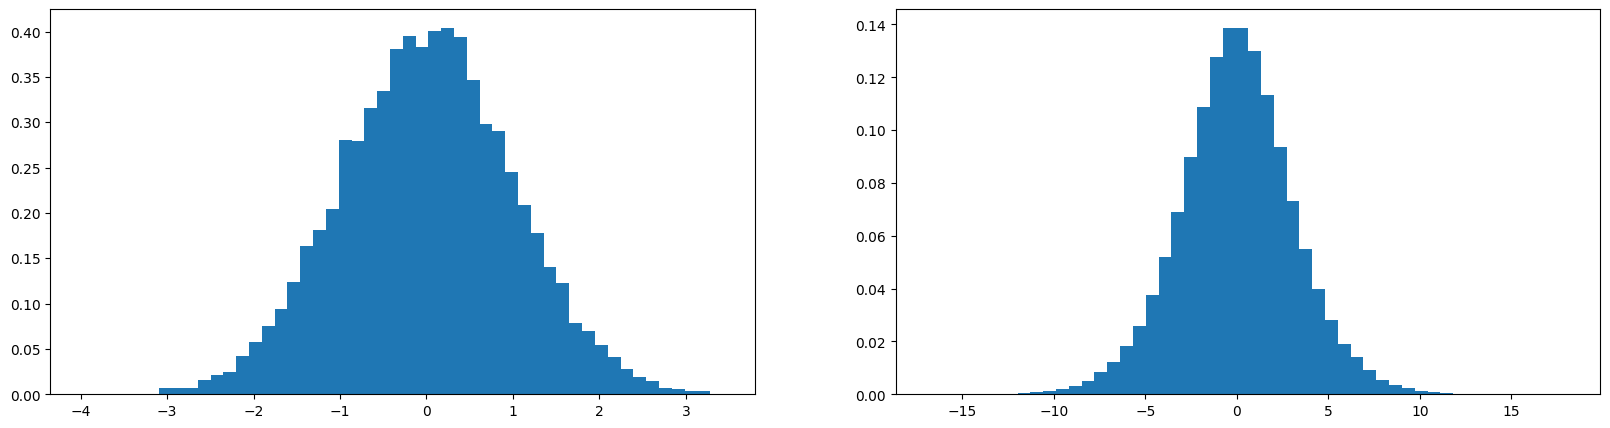

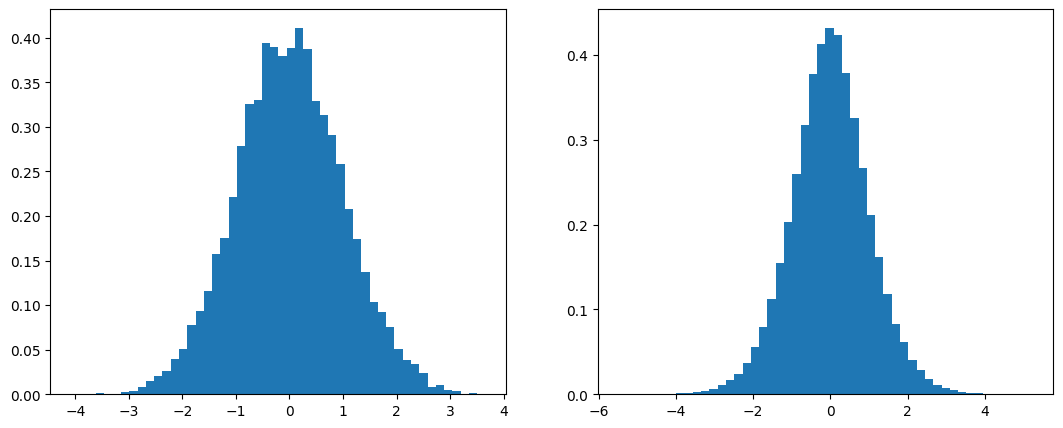

In [7]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
# x (the input) is standard normal distribution, we need to keep the output (y) the same distribution.
# right now the std of y is 3.17 and we aim at getting it to 1.
# empirically we'll achieve it by dividing w by the sqaure root of fan_in (number of inputs).
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# adjust w so that y follows std normal distribution
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(132)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [8]:
# single batch
batch_size = 32
n = batch_size
# minibatch construct
ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtrain[ix], Ytrain[ix]

In [9]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
# ------------------------------------------------------
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*bndiff2.sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# ------------------------------------------------------
# Non-linearity
h = torch.tanh(hpreact)
# linear layer 2
logits = h @ W2 + b2
# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3321, grad_fn=<NegBackward0>)

In [10]:
emb.shape, C.shape, Xb.shape
# emb = C[Xb]

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [11]:
# Exercise 1: backprop through the exactly all the variables
# as they are defined in the forward pass above, one by one.
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = 1.0/probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = norm_logits.exp() * dcounts
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1)*torch.ones_like(bnvar) * dbnvar
dbndiff += 2*bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn += 1/n * torch.ones_like(dhprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    dC[Xb[i, j]] += demb[i, j, :]

cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bngain", dbngain, bngain)
cmp("bnraw", dbnraw, bnraw)
cmp("bnbias", dbnbias, bnbias)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
cmp("bndiff", dbndiff, bndiff)
cmp("bnvar", dbnvar, bnvar)
cmp("bndiff2", dbndiff2, bndiff2)
cmp("hprebn", dhprebn, hprebn)
cmp("bnmeani", dbnmeani, bnmeani)
cmp("embcat", dembcat, embcat)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)
cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnraw           | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bnbias  

In [12]:
# @title cross entropy backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp("logits", dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [14]:
# @title BatchNorm derivation
dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))

cmp("hprebn", dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-11
